# Short summary of the project:
We work at a startup that sells food products. I will investigate user behavior for the app for startup that sells food products and perform A/A and A/B testing. The test will decide if we should change the fonts for the entire app, if it would help bring more customers. I will also point out all other observations that may help increase profit. 

First we study the sales funnel. Find out how users reach the purchase stage and how many users actually make it to this stage, how many get stuck at previous stages, which stages in particular.
Then we look at the results of an A/A/B test.The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. They decide to make a decision based on the results of an A/A/B test.
The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. Find out which set of fonts produces better results.
Creating two A groups has certain advantages. We can make it a principle that we will only be confident in the accuracy of our testing when the two control groups are similar. If there are significant differences between the A groups, this can help us uncover factors that may be distorting the results. Comparing control groups also tells us how much time and data we'll need when running further tests.

## Description of the data:


/datasets/logs_exp_us.csv

Each log entry is a user action or an event.

EventName — event name

DeviceIDHash — unique user identifier

EventTimestamp — event time

ExpId — experiment number: 246 and 247 are the control groups, 248 is the test group

In [5]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy import stats as st
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math as mth
from datetime import datetime 
import missingno as msno

In [7]:
data_events = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

data_events.columns = ['event_name', 'user_id', 'timestamp' , 'experiment_number']
data_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name           244126 non-null object
user_id              244126 non-null int64
timestamp            244126 non-null int64
experiment_number    244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Step one: preprocessing

### Processessing and looking for duplicates.
It would be interesting to know how much time the clients stayed on the site and if there are any outliers (a very long time spent on the site or way to many actions).

In [8]:
data_events.describe()

,user_id,timestamp,experiment_number
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


In [9]:
#looking for duplicates: finding duplicates in each column.
for i in data_events[data_events.duplicated()].columns:
    print(i, ':', data_events[data_events.duplicated()][i].nunique())

event_name : 5
user_id : 237
timestamp : 352
experiment_number : 3


In [10]:
#changing datatypes where necessary. Adding a date and time column and a separate column for dates.
data_events['datetime'] = pd.to_datetime(data_events['timestamp'], unit='s')    
data_events['date'] = pd.to_datetime(data_events['datetime']).dt.date
data_events['time'] = pd.to_datetime(data_events['datetime']).dt.time

In [11]:
#continuing with duplicates
data_events[data_events.duplicated()]['date'].unique()

array([datetime.date(2019, 7, 30), datetime.date(2019, 7, 31),
       datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 3), datetime.date(2019, 8, 4),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7)], dtype=object)

Duplicates exist for more than one week while the whole testing only took one week. This is a bad sign and would usually be addressed. In reality I would get back to my colleagues and ask for advise and also ask for more information on the dataset. However, since we don't know where the data came from, we have to just drop the duplicates.

In [12]:
data_events = data_events.drop_duplicates()
data_events.duplicated().sum()

0

### looking for NaN

In [13]:
#looking for NaN
data_events.isna().any()
data_events.isnull().any()

event_name           False
user_id              False
timestamp            False
experiment_number    False
datetime             False
date                 False
time                 False
dtype: bool

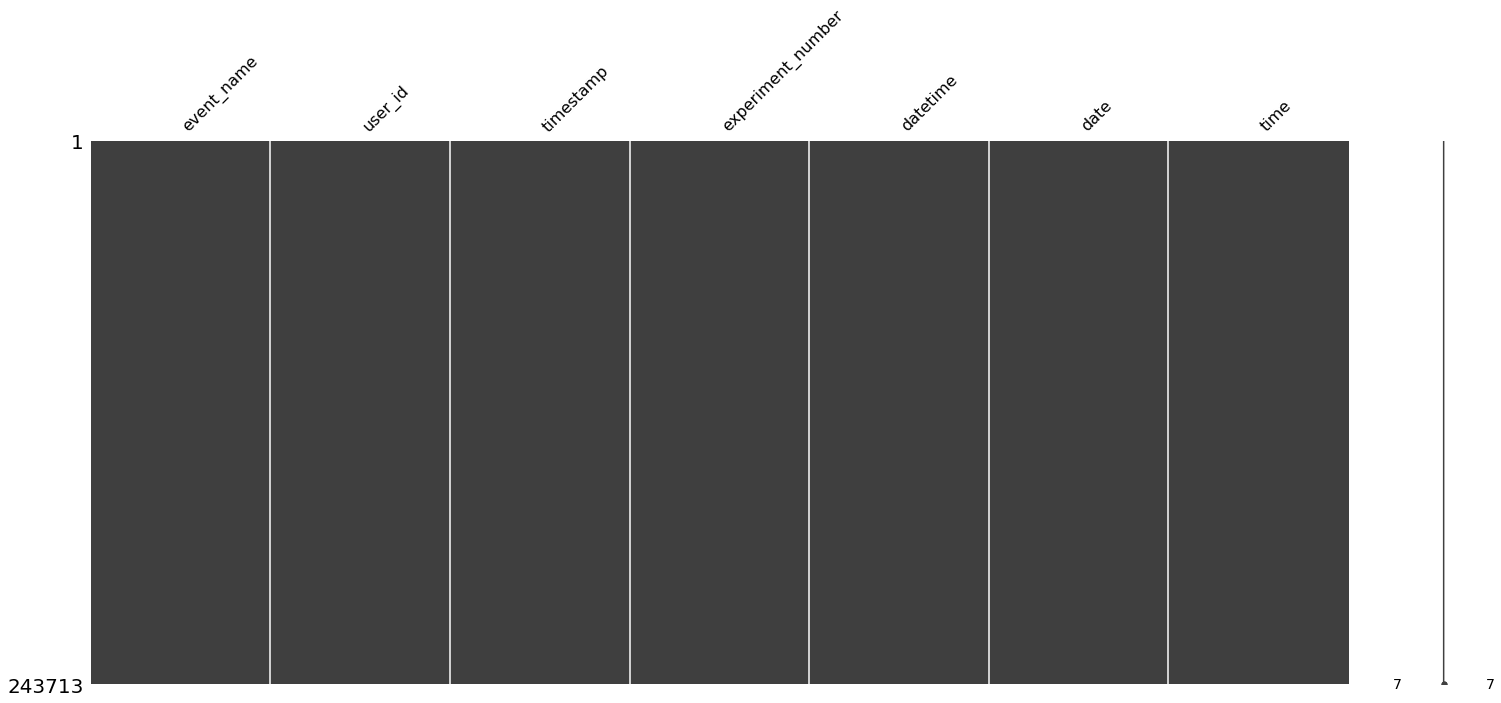

In [14]:
msno.matrix(data_events) #As we can see - none!

## Studying the data

### finding the number of users and events
Answering the questions "how many events are in the logs?" and "How many users are there?" below. We can also see that the most popular event is MainScreenAppear. This is probably the sign that it is the first event.

In [9]:
data_events['event_name'].value_counts() #There are four events in total

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [10]:
data_events['event_name'].describe()


count               243713
unique                   5
top       MainScreenAppear
freq                119101
Name: event_name, dtype: object

In [11]:
display(data_events['user_id'].value_counts().head())
display(data_events['user_id'].value_counts().tail()) #we have 7551 users

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
Name: user_id, dtype: int64

3336727186673646149    1
1657967711232741323    1
425817683219936619     1
4089770943116790924    1
1083512226259476085    1
Name: user_id, dtype: int64

### Average number of events per user.
Below I am answering the question "What's the average number of events per user?" I will also calculate number of unique events per user. This way we will see how many users stopped at the first stage and how many went all the way.

In [12]:
events_per_user = data_events.groupby('user_id')['event_name'].count()
events_per_user.sort_values(ascending=False).head()
display(events_per_user.describe())

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

In [13]:
events_per_user.describe(percentiles=[.90, .95, .99])

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
50%        20.000000
90%        64.000000
95%        89.000000
99%       200.500000
max      2307.000000
Name: event_name, dtype: float64

In [14]:
events_per_user.mean() #average number of events per user

32.27559263673685

In [15]:
events_per_user.median()

20.0

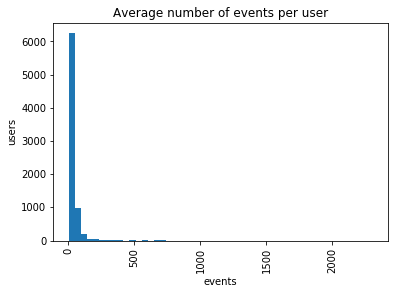

In [16]:
plt.hist(events_per_user, bins=50) 
plt.xticks(rotation=90)
plt.xlabel('events')
plt.ylabel('users')
plt.title('Average number of events per user')
plt.show()

We can see from the research above that while average number of events is 32. We can see that 75% of users have 37 events or less and 99% have 200 or less. That means the highest values are outliers and are probably skewing the mean to the right. In this case I think the median may be usefull to look at. The median is 20 and it may be closer to the actual average number of events per user if we don't count the outliers.

In [17]:
data_events.groupby('user_id')['event_name'].nunique().reset_index().groupby('event_name')['user_id'].nunique()
#calculating number of unique events per user


event_name
1    2707
2    1021
3     317
4    3035
5     471
Name: user_id, dtype: int64

### Studying datetime column.

Below I am completing the task: "Find period of time the data covers, the maximum and the minimum date. Plot a histogram by date and time."

In [18]:
data_events['date'].value_counts() #max date is 2019-08-07 and min date is 2019-07-25 

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
2019-07-31     2030
2019-07-30      412
2019-07-29      184
2019-07-28      105
2019-07-27       55
2019-07-26       31
2019-07-25        9
Name: date, dtype: int64

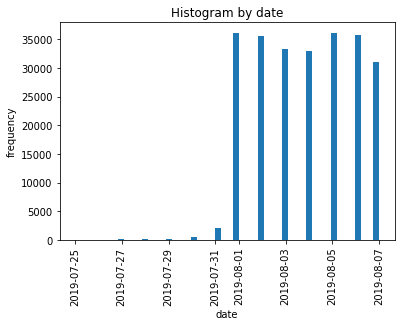

In [19]:
plt.hist(data_events['date'], bins=50) 
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('frequency')
plt.title('Histogram by date')
plt.show()

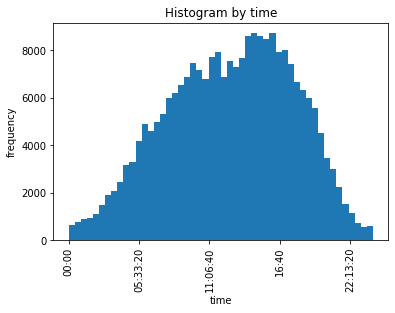

In [20]:
plt.hist(data_events['time'], bins=50) 
plt.xticks(rotation=90)
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Histogram by time')
plt.show()

<div class="alert alert-warning">
<b>Reviewer's comment: </b> You can make your histograms more vivid with tuning <code>bins</code> parameter.
</div>

### Dropping irrelevant data.

From the graphs I would say that we should stop at 08.01 after looking at the datetime histogram. I thing we should drop the data before that, there is not enough data there.

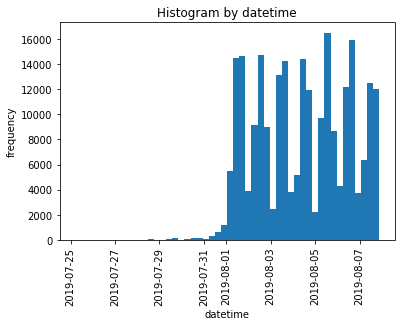

In [21]:
plt.hist(data_events['datetime'], bins=50) #08.01 is where I would stop. We can clearly see it on the histogram
plt.xticks(rotation=90)
plt.xlabel('datetime')
plt.ylabel('frequency')
plt.title('Histogram by datetime')
plt.show()

In [22]:
display(data_events['user_id'].nunique())
display(data_events['experiment_number'].value_counts())
display(data_events['event_name'].value_counts())

7551

248    85582
246    80181
247    77950
Name: experiment_number, dtype: int64

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [23]:
data_old = data_events


display(data_old['user_id'].nunique())
display(data_old['experiment_number'].value_counts())
display(data_old['event_name'].value_counts())

7551

248    85582
246    80181
247    77950
Name: experiment_number, dtype: int64

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [24]:
number_one_old = data_old.loc[data_old['experiment_number'] == 248, 'experiment_number'].count() #separating the data on each experiment number.
display(number_one_old)

number_two_old = data_old.loc[data_old['experiment_number'] == 246, 'experiment_number'].count()
display(number_two_old)

number_three_old = data_old.loc[data_old['experiment_number'] == 247, 'experiment_number'].count()
display(number_three_old)


85582

80181

77950

In [25]:
user_id_old = data_old['user_id'].nunique() #separating data on user id
display(user_id_old)


7551

In [26]:
MainScreen_old = data_old.loc[data_old['event_name'] == 'MainScreenAppear', 'event_name'].count() #separating the data on each event
display(MainScreen_old)

OffersScreen_old = data_old.loc[data_old['event_name'] == 'OffersScreenAppear', 'event_name'].count()
display(OffersScreen_old)

CartScreen_old = data_old.loc[data_old['event_name'] == 'CartScreenAppear', 'event_name'].count()
display(CartScreen_old)

PaymentScreen_old = data_old.loc[data_old['event_name'] == 'PaymentScreenSuccessful', 'event_name'].count()
display(PaymentScreen_old)

Tutorial_old = data_old.loc[data_old['event_name'] == 'Tutorial', 'event_name'].count()
display(Tutorial_old)

119101

46808

42668

34118

1018

In [27]:
data_events['date_str'] = data_events['date'].astype(str)
data_events.drop(data_events[data_events['date_str'].isin(['2019-07-25', '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29', '2019-07-30', '2019-07-31' ])].index, inplace=True) 
data_events['date'].value_counts()

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
Name: date, dtype: int64

In [28]:
display(data_events['user_id'].nunique())
display(data_events['experiment_number'].value_counts())
display(data_events['event_name'].value_counts())

7534

248    84563
246    79302
247    77022
Name: experiment_number, dtype: int64

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [29]:
number_one_new = data_events.loc[data_events['experiment_number'] == 248, 'experiment_number'].count()
display(number_one_new)

number_two_new = data_events.loc[data_events['experiment_number'] == 246, 'experiment_number'].count()
display(number_two_new)

number_three_new = data_events.loc[data_events['experiment_number'] == 247, 'experiment_number'].count()
display(number_three_new)

84563

79302

77022

In [30]:
Group_B_difference = number_one_old - number_one_new  #calculating the difference in numbers for each experiment number

Group_A_one_difference = number_two_old - number_two_new

Group_A_two_difference = number_three_old - number_three_new
print(Group_B_difference, Group_A_one_difference, Group_A_two_difference)



Group_B_difference_prcnt =  Group_B_difference/ (number_one_old/100)   #calculating the difference in percentages for each experiment number

Group_A_one_difference_prcnt = Group_A_one_difference/ (number_two_old/100)

Group_A_two_difference_prcnt = Group_A_two_difference/ (number_three_old/100)
print(Group_B_difference_prcnt, Group_A_one_difference_prcnt, Group_A_two_difference_prcnt) 

1019 879 928
1.1906709354770861 1.096269689826767 1.1905067350865939


We can see above that we only lost 1019, 879 and 928 rows and only 1,19% for the control group number 248, 1,09% for group number 246 and 1,19% for group number 247

In [31]:
user_id_new = data_events['user_id'].nunique() 
display(user_id_new)

7534

In [32]:
user_id_change = user_id_old - user_id_new #calculating difference in numbers for user id
user_id_change_prcnt = user_id_change/(user_id_old/100) #calculating difference in numbers for user id in percentages
display(user_id_change)
display(user_id_change_prcnt)

17

0.22513574361011784

We can see above that we only lost 17 rows and only 0,22% for user id column.

In [33]:
MainScreen_new = data_events.loc[data_events['event_name'] == 'MainScreenAppear', 'event_name'].count() #separating the data on each event
display(MainScreen_new)

OffersScreen_new = data_events.loc[data_events['event_name'] == 'OffersScreenAppear', 'event_name'].count()
display(OffersScreen_new)

CartScreen_new = data_events.loc[data_events['event_name'] == 'CartScreenAppear', 'event_name'].count()
display(CartScreen_new)

PaymentScreen_new = data_events.loc[data_events['event_name'] == 'PaymentScreenSuccessful', 'event_name'].count()
display(PaymentScreen_new)

Tutorial_new = data_events.loc[data_events['event_name'] == 'Tutorial', 'event_name'].count()
display(Tutorial_new)

117328

46333

42303

33918

1005

In [34]:
MainScreen_difference = MainScreen_old - MainScreen_new  #calculating the difference in numbers for each event

OffersScreen_difference = OffersScreen_old - OffersScreen_new

CartScreen_difference = CartScreen_old - CartScreen_new

PaymentScreen_difference = PaymentScreen_old - PaymentScreen_new

Tutorial_difference = Tutorial_old -  Tutorial_new

print(MainScreen_difference, OffersScreen_difference, CartScreen_difference, PaymentScreen_difference, Tutorial_difference)





MainScreen_difference_prcnt = MainScreen_difference/(MainScreen_old/100) #calculating the difference in numbers for each event in percentages

OffersScreen_difference_prcnt = OffersScreen_difference/(OffersScreen_old/100)

CartScreen_difference_prcnt = CartScreen_difference/(CartScreen_old/100)

PaymentScreen_difference_prcnt = PaymentScreen_difference/(PaymentScreen_old/100)

Tutorial_difference_prcnt = Tutorial_difference/(Tutorial_old/100)

print(MainScreen_difference_prcnt, OffersScreen_difference_prcnt, CartScreen_difference_prcnt, PaymentScreen_difference_prcnt, Tutorial_difference_prcnt)




1773 475 365 200 13
1.4886524882242802 1.014783797641429 0.855442017436955 0.586200832405182 1.2770137524557956


We can see above that we only lost 1773, 475, 365, 200, 13 rows for each event. In percentages we lost only 1,48% for MainScreen, 1,014% for the OffersScreen, 0,85% for CartScreen, 0.58% for PaymentScreen and 1,27% for Tutorial.

### Calculating the loss of data.

I looked at user_id, event_name and experiment_number columns before and after dropping the rows.
We went from 7551 to 7534 unique users which is very little, we only lost 17 rows. We lost only 0,2% of the users. 

For groups, we went from 

248    85582
246    80181
247    77950

to

248    84563
246    79302
247    77022

We lost only 1019, 879 and 928 rows respectively.

We lost this much data for each group: 

248: 1.19%
246: 1.09%
247: 1.19%

For number of events we went from this: 


MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018


to this:

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005

This is the percentage we lost: 

MainScreenAppear           1.48%
OffersScreenAppear         1.014%
CartScreenAppear           0.85%
PaymentScreenSuccessful    0.58%
Tutorial                   1.27%




Overall we lost very little data.

In [35]:
data_events['experiment_number'].value_counts() #making sure we have data on all experimental groups.

248    84563
246    79302
247    77022
Name: experiment_number, dtype: int64

## Studying the event funnel

Studying event funnel and invewtigating user behaviour. Below we will see the events by frequency and then by the number of unique users. I also conclude that the tutorial is not a necessary step from this data. 

In [36]:
data_events['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

### Researching user behavior by event

In [37]:
event_by_user = data_events.groupby('event_name')['user_id'].nunique() #Sort the events by the number of users
event_by_user.sort_values(ascending=False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

Below is the proportion of users who performed each action at least once:

In [38]:
data_events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)/data_events['user_id'].nunique()


event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: user_id, dtype: float64

Below I also calculate how many users completed each number of steps and how many completed all of them, how many users stopped at each event. Excluding tutorial, only 3036 users made completed payment. Looking at the proportion above, we see that there is approximately 47% conversion rate from visiting main screen to purchase. Below i will also reseach how many of the users made repeat purchase.

In [39]:
data_events.groupby('user_id')['event_name'].nunique().reset_index().groupby('event_name')['user_id'].nunique()

event_name
1    2717
2    1004
3     318
4    3029
5     466
Name: user_id, dtype: int64

Calculating repeated actions: how many of clients made a second purchase.


In [40]:
at_least_once = data_events.groupby(['user_id','event_name'])['datetime'].count().reset_index()
at_least_once #looking at how many times each user performed each action.

,user_id,event_name,datetime
0,6888746892508752,MainScreenAppear,1
1,6909561520679493,CartScreenAppear,1
2,6909561520679493,MainScreenAppear,2
3,6909561520679493,OffersScreenAppear,1
4,6909561520679493,PaymentScreenSuccessful,1
...,...,...,...
20120,9220879493065341500,CartScreenAppear,1
20121,9220879493065341500,MainScreenAppear,4
20122,9220879493065341500,OffersScreenAppear,1
20123,9221926045299980007,MainScreenAppear,7


In [41]:
main_screen = at_least_once.query('event_name == "MainScreenAppear"')
cart_screen = at_least_once.query('event_name == "CartScreenAppear"')
offers_screen = at_least_once.query('event_name == "OffersScreenAppear"')
payment_screen = at_least_once.query('event_name == "PaymentScreenSuccessful"')
tutorial = at_least_once.query('event_name == "Tutorial"')

In [42]:
main_screen['datetime'].value_counts()

6      411
2      399
4      396
5      383
3      378
      ... 
164      1
156      1
144      1
140      1
157      1
Name: datetime, Length: 120, dtype: int64

In [43]:
cart_screen['datetime'].value_counts()

1      472
2      433
3      387
4      362
5      290
      ... 
413      1
527      1
41       1
53       1
931      1
Name: datetime, Length: 116, dtype: int64

In [44]:
offers_screen['datetime'].value_counts()

1      681
2      447
3      373
4      338
5      318
      ... 
97       1
89       1
73       1
69       1
291      1
Name: datetime, Length: 99, dtype: int64

In [45]:
payment_screen['datetime'].value_counts()

1      574
2      498
3      430
4      361
5      288
      ... 
762      1
33       1
55       1
59       1
570      1
Name: datetime, Length: 108, dtype: int64

In [46]:
tutorial['datetime'].value_counts()

1     756
2      56
3      19
5       3
4       2
27      1
16      1
8       1
6       1
Name: datetime, dtype: int64

As is obvious from above, we se a lot of abnormal user behavior.First of all, it is weird that the majority of users saw the Main Screen page not one but from 2 to 6 times. There may be something wrong with this page, maybe it doesn't function properly. This needs to be addressed. Also we see abnormal values where people return to screens hundreds of times. This users' behavior also needs to be investigated separately. There is a possibility that they are spammers or have other malicious intentions, but there may also be something wrong with the way we collect the data (for example, maybe there is a bug that counts same actions multiple times). However, they make a big portion of data and i do not feel comfortable removing them as outliers since it is a high percentage of users.
Let's see returning users compared to all users. Let's look at the users who repeated action more than once.

In [47]:
data_events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

In [48]:
at_least_once[at_least_once.datetime>=2].groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           7173
OffersScreenAppear         3912
CartScreenAppear           3262
PaymentScreenSuccessful    2965
Tutorial                     84
Name: user_id, dtype: int64

### Finding return customers.

So,for exampleout of 7438 users that went to the main screen 7195 did it again. Now we will see % of return customers

In [49]:
at_least_once[at_least_once.datetime>=2].groupby('event_name')['user_id'].nunique().sort_values(ascending=False)/data_events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           0.966842
OffersScreenAppear         0.851731
CartScreenAppear           0.873594
PaymentScreenSuccessful    0.837807
Tutorial                   0.100000
Name: user_id, dtype: float64

We can see above that the percentage of returning users is very high, especially for an online app!

Sequence of events. It can be seen below. 

In [50]:
data_events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

I think that the order is as we see drom highest to lowest. I do not think they are all part of a single sequence and it does not seem necessary to complete all to procede to payment. For example, someone could be sent a link directly to a specific screen, for example, payment. I assume that tutorial is not a necessary part of the funnel since many users proceded to payment without it. 

Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)
Below I will calculate percentage change between stages. I will drop tutorial since it is redundant.

### Removing the redundant stage. 

In [51]:

funnel = data_events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
funnel['event_name'] = funnel['event_name'].astype(str)
funnel = data_events.query( 'event_name != "Tutorial" ')
funnel

,event_name,user_id,timestamp,experiment_number,datetime,date,time,date_str
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01,00:10:15,2019-08-01
...,...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07,21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07,21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07,21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07,21:14:58,2019-08-07


In [52]:
funnel['percentage_change'] = funnel['user_id'].pct_change() 
funnel

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,event_name,user_id,timestamp,experiment_number,datetime,date,time,date_str,percentage_change
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,00:08:00,2019-08-01,NaN
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,00:08:55,2019-08-01,0.000000
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,00:08:58,2019-08-01,0.000000
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,00:08:59,2019-08-01,-0.616360
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01,00:10:15,2019-08-01,2.417109
...,...,...,...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07,21:12:25,2019-08-07,-0.199643
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07,21:13:59,2019-08-07,0.271800
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07,21:14:43,2019-08-07,-0.017579
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07,21:14:58,2019-08-07,0.000000


In [53]:
data_events.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)/data_events['user_id'].nunique()

event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: user_id, dtype: float64

As we can see, we lose most users at the OffersScreenAppear stage. We lose almost 38% of clients there. There is something wrong with this page, we should report it to the site developpment team.
Overall 47 % of users make the entire journey from mainscreen to payment. I exclude tutorial since it is clearly rarely used.

### Studying funnel by group.

Below I split data by group and make some more calculations I find useful. 

In [54]:
funnel_by_groups = []
for i in data_events.experiment_number.unique():
    group = data_events[data_events.experiment_number == i].groupby(['event_name', 'experiment_number'])['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
    display(group)
    funnel_by_groups.append(group)


,event_name,experiment_number,user_id
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542
0,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200
4,Tutorial,246,278


,event_name,experiment_number,user_id
1,MainScreenAppear,247,2476
2,OffersScreenAppear,247,1520
0,CartScreenAppear,247,1238
3,PaymentScreenSuccessful,247,1158
4,Tutorial,247,283


,event_name,experiment_number,user_id
1,MainScreenAppear,248,2493
2,OffersScreenAppear,248,1531
0,CartScreenAppear,248,1230
3,PaymentScreenSuccessful,248,1181
4,Tutorial,248,279


Above we see funnel for each group.

In [55]:
funnel_by_groups = pd.concat(funnel_by_groups)


In [56]:
min_time = pd.pivot_table(data_events[data_events['event_name'] != 'Tutorial'], index = ['user_id'], columns = ['event_name'], values = ['datetime'], aggfunc=min)['datetime']
min_time

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
user_id,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45
...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT


In [57]:
min_time_new_order = min_time[['MainScreenAppear','PaymentScreenSuccessful']]

In [58]:
# Here we can also see the time difference between first and last steps.

min_time_diff = min_time_new_order - min_time_new_order.shift(+1, axis=1)
min_time_diff

event_name,MainScreenAppear,PaymentScreenSuccessful
user_id,,
6888746892508752,NaT,NaT
6909561520679493,NaT,0 days 00:00:04
6922444491712477,NaT,0 days 00:00:07
7435777799948366,NaT,NaT
7702139951469979,NaT,1 days 09:58:51
...,...,...
9217594193087726423,NaT,NaT
9219463515465815368,NaT,1 days 11:25:50
9220879493065341500,NaT,NaT


In [59]:
min_time_diff['PaymentScreenSuccessful'].value_counts().sort_values(ascending=False)

0 days 00:00:02      145
0 days 00:00:03      144
0 days 00:00:04      134
0 days 00:00:05      107
0 days 00:00:06       82
                    ... 
-2 days +22:57:40      1
1 days 07:10:06        1
0 days 11:38:06        1
4 days 09:44:05        1
0 days 00:05:11        1
Name: PaymentScreenSuccessful, Length: 2035, dtype: int64

In [60]:
min_time_diff['PaymentScreenSuccessful'].mean() #average time it takes for users to get from main to the payment screen. 

Timedelta('0 days 12:30:56.080209')

In [61]:
min_time_diff['PaymentScreenSuccessful'].median() 

Timedelta('0 days 00:03:27')

In [62]:
min_time_new_order = min_time[['MainScreenAppear','OffersScreenAppear']]
min_time_diff = min_time_new_order - min_time_new_order.shift(+1, axis=1)
display(min_time_diff['OffersScreenAppear'].mean()) #average time it takes for users to get from main to the offers screen. 
display(min_time_diff['OffersScreenAppear'].median())

Timedelta('0 days 07:40:04.275100')

Timedelta('0 days 00:00:19')

In [63]:
min_time_new_order = min_time[['MainScreenAppear','CartScreenAppear']]
min_time_diff = min_time_new_order - min_time_new_order.shift(+1, axis=1)
display(min_time_diff['CartScreenAppear'].mean()) #average time it takes for users to get from main to the cart screen. 
display(min_time_diff['CartScreenAppear'].median())

Timedelta('0 days 10:35:12.408253')

Timedelta('0 days 00:01:01')

In [64]:
min_time_new_order = min_time[['OffersScreenAppear','CartScreenAppear']]
min_time_diff = min_time_new_order - min_time_new_order.shift(+1, axis=1)
display(min_time_diff['CartScreenAppear'].mean()) #average time it takes for users to get from offers to the cart screen. 
display(min_time_diff['CartScreenAppear'].median())

Timedelta('0 days 07:39:18.228866')

Timedelta('0 days 00:00:07')

In [65]:
min_time_new_order = min_time[['OffersScreenAppear','PaymentScreenSuccessful']]
min_time_diff = min_time_new_order - min_time_new_order.shift(+1, axis=1)
display(min_time_diff['PaymentScreenSuccessful'].mean()) #average time it takes for users to get from offers to the payment screen. 
display(min_time_diff['PaymentScreenSuccessful'].median())

Timedelta('0 days 10:03:50.189977')

Timedelta('0 days 00:00:22')

In [66]:
min_time_new_order = min_time[['CartScreenAppear','PaymentScreenSuccessful']]
min_time_diff = min_time_new_order - min_time_new_order.shift(+1, axis=1)
display(min_time_diff['PaymentScreenSuccessful'].mean()) #average time it takes for users to get from cart to the payment screen. 
display(min_time_diff['PaymentScreenSuccessful'].median())

Timedelta('0 days 02:32:25.174872')

Timedelta('0 days 00:00:00')

### Conclusion for this section of research
Above we have looked at the time it took to get from each step to each. I used median as well as mean to account for possibility of abnormaly large numbers skewing the mean. If we look at the median we see that it takes comparatively long time to get from main to offers. 21 second is a lot for two consecutive steps; this may be the reason the users quit most often at this step, since 21 seconds is a long time for a next page to load, the users may have clicked off.

## Studying the results of the experiment

Below I study the results of the experiment

### Checking that there is equal number of users for each group and no repetition.
How many users are there in each group? We see below that the distribution is more or less equal. 

In [67]:
data_events.groupby('experiment_number')['user_id'].nunique() 

experiment_number
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Now we will check that no users appear in two groups at the same time. We can see from code below that there is none!

In [68]:
data_events.groupby('user_id')['experiment_number'].nunique().reset_index().query('experiment_number>1')

,user_id,experiment_number


### A/A testing
We have two control groups in the A/A test, where we check our mechanisms and calculations. Below we will research if there is a statistically significant difference between samples 246 and 247. To find which group is most profitable it makes sence to compare the number of users that proceded to each step, so, find user conversion between events for all groups. The most popular event would be Main Screen, however, I will write one function and run it not just for that but for all events and all groups. I will use proportions test for this since our data fits all requirements. 

In [69]:
test_1 = data_events[data_events.experiment_number==246]['user_id'].nunique()
test_2 = data_events[data_events.experiment_number==247]['user_id'].nunique()
control = data_events[data_events.experiment_number==248]['user_id'].nunique() #trials - all users in the group
test_1_2 = data_events[data_events.experiment_number!=248]['user_id'].nunique()

In [70]:
pivot = data_events.pivot_table(index='event_name', columns = 'experiment_number', values='user_id', aggfunc=lambda x: x.nunique()).reset_index()
pivot #successes - number of users converted at each stage

experiment_number,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


### Formulating the hypotheses that will be used in all the testing for all groups and events.
The H0 is that there IS a significant difference between number of users performing the event (user converstion) for the  two control groups. The H1 is that there is no reason to consider the difference for the  two control groups significant. So, I will test for significant difference between groups on each stage.

In [71]:
def check_hypothesis(group1, group2, event, alpha=0.5):
    success1 = pivot[pivot.event_name==event][group1].iloc[0]
    success2 = pivot[pivot.event_name==event][group2].iloc[0]
    
    trials1 = data_events[data_events.experiment_number==group1]['user_id'].nunique()
    trials2 = data_events[data_events.experiment_number==group2]['user_id'].nunique()
    
    p1 = success1/trials1

    p2 = success2/trials2

    p_combined = (success1 +  success2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined + (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    p_value = ( 1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value:' , p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there IS a significant difference between proportions for the  two control groups for", event, "between groups", group1, group2)
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the", event, "between groups", group1, group2, "significant")


For each of the events the alpha level is 0.05. Each time, for each event, the H0 is that there IS a significant difference between number of users performing the event (user converstion) for the two control groups. The H1 is that there is no reason to consider the difference for the two control groups significant. We will see for each event first the comparison between users from the two A groups, then between each A group and B group, and then we add the two A groups together and compare these results with the results for the B group.

Below I am performing the test for the two A groups.

In [72]:
for i in pivot.event_name.unique():
    print(i)
    check_hypothesis(246 ,247 ,i, alpha=0.05)


CartScreenAppear
p_value: 0.9808215720223084
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the CartScreenAppear between groups 246 247 significant
MainScreenAppear
p_value: 0.9991675913808951
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the MainScreenAppear between groups 246 247 significant
OffersScreenAppear
p_value: 0.9837801761211138
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the OffersScreenAppear between groups 246 247 significant
PaymentScreenSuccessful
p_value: 0.9741284339349139
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the PaymentScreenSuccessful between groups 246 247 significant
Tutorial
p_value: 0.9983427578903803
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for t

We failed to reject the hypothesis for each event for teo A groups. This means we can compare group B (control group) to any of the A groups, the difference is not significant. This means that we can trust the A/B test. Below I will use the same function to perform A/B testing.

In [73]:
for i in pivot.event_name.unique():
    print(i)
    check_hypothesis(246 ,248 ,i, alpha=0.05)

CartScreenAppear
p_value: 0.971910014269989
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the CartScreenAppear between groups 246 248 significant
MainScreenAppear
p_value: 0.9970602603534895
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the MainScreenAppear between groups 246 248 significant
OffersScreenAppear
p_value: 0.982357405037253
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the OffersScreenAppear between groups 246 248 significant
PaymentScreenSuccessful
p_value: 0.9796404293864218
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the PaymentScreenSuccessful between groups 246 248 significant
Tutorial
p_value: 0.9953581939103768
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the

In [74]:
for i in pivot.event_name.unique():
    print(i)
    check_hypothesis(247 ,248 ,i, alpha=0.05)

CartScreenAppear
p_value: 0.9910858453847207
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the CartScreenAppear between groups 247 248 significant
MainScreenAppear
p_value: 0.9978926849501784
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the MainScreenAppear between groups 247 248 significant
OffersScreenAppear
p_value: 0.9985775282491278
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the OffersScreenAppear between groups 247 248 significant
PaymentScreenSuccessful
p_value: 0.994484593360293
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the PaymentScreenSuccessful between groups 247 248 significant
Tutorial
p_value: 0.993700934575513
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the

As we can see, the difference between fonts is not significant for each event, it seems that the change of fonts does not change much. 

### Working with the combined results for the control groups

In [75]:
df2 = {
    'experiment_number' : 249,
     'user_id' : data_events[data_events.experiment_number!=248]['user_id'],
     'event_name' : data_events[data_events.experiment_number!=248]['event_name']
    
}

df_2 = pd.DataFrame(df2)
df_2

data_new = data_events.append(df_2, ignore_index=True)


data_new.drop(data_new[data_new['experiment_number'].isin(['246', '247'])].index, inplace=True) 


pivot2 = data_new.pivot_table(index='event_name', columns = 'experiment_number', values='user_id', aggfunc=lambda x: x.nunique()).reset_index()
pivot2

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




experiment_number,event_name,248,249
0,CartScreenAppear,1230,2504
1,MainScreenAppear,2493,4926
2,OffersScreenAppear,1531,3062
3,PaymentScreenSuccessful,1181,2358
4,Tutorial,279,561


In [76]:
def check_hypothesis_new(group1, group2, event, alpha=0.5):
    success1 = pivot2[pivot2.event_name==event][group1].iloc[0]
    success2 = pivot2[pivot2.event_name==event][group2].iloc[0]
    
    trials1 = data_new[data_new.experiment_number==group1]['user_id'].nunique()
    trials2 = data_new[data_new.experiment_number==group2]['user_id'].nunique()
    
    p1 = success1/trials1

    p2 = success2/trials2

    p_combined = (success1 +  success2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined + (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    p_value = ( 1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value:' , p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there IS a significant difference between proportions for the  two control groups for", event, "between groups", group1, group2)
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the", event, "between groups", group1, group2, "significant")

In [77]:
for i in pivot2.event_name.unique():
    print(i)
    check_hypothesis_new(248 ,249 ,i, alpha=0.05)

CartScreenAppear
p_value: 0.9815606690192729
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the CartScreenAppear between groups 248 249 significant
MainScreenAppear
p_value: 0.9974795015447504
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the MainScreenAppear between groups 248 249 significant
OffersScreenAppear
p_value: 0.990499469275973
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the OffersScreenAppear between groups 248 249 significant
PaymentScreenSuccessful
p_value: 0.9925837711337862
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the PaymentScreenSuccessful between groups 248 249 significant
Tutorial
p_value: 0.9945291163114705
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for th

Above I did the test for the combined results for the control groups. We can see from the results of the test for the two groups combined and the control group. We can see from the result of the tests for each event that adding the two groups together did not change the results of the test; they are the same as for the two groups separately. I draw the conclusion that change in fonts did not make a big difference for the site. 

### Discussing the alpha level and Bolnferroni correction.

Now to the last question. Here we should use the Bolnferroni correction because we are dealing with the multiple comparison problem. We need to delete alpha by the number of tests :  {\displaystyle p_{i}\leq {\frac {\alpha }{m}}}{\displaystyle p_{i}\leq {\frac {\alpha }{m}}}

Since we have 5 events and 3 comparisons between groups, we would need to divide it by 15. However, we know that where one error decreaces, the other increases. 

However. The Bolnferroni correction decereaces possibility of type one error: a chance to reject a true H0. But, when the chance of one error type decreaces, the chance of error 2 increases: a chance to accept a false H0. 
In our case the 2type error is more important. If we make the type 1 error, everything will stay the same; however, with the type 2 error we will potentially not see the difference between groups and can miss a chance to improve(for example, if the new font is better). Overall, the higher type 2 error would be worse for us in this situation. At the same time, even with higher alpha value of 0.05 we failed to reject all null hypothesis for each event and all groups. With even lower alpha level thanks to the Bolnferroni correction the p-value would not go below alpha and the result would be the same.

Another thing to consider is: the Bolnferroni correction is usually used for the same types of tests and same sampling, but here we are not doing any sampling. Sampling increase chance of error and we are not working with samples, there is no chance to sample same users by accident. Overall my conclusion is that it is not necessary to perform the Bolnferroni correction in this specuphic case. 

## Conclusion

Generall conclusion:

From the overall analysis I make the following conclusions:
Firstly, the data is corrupted: there are many duplicates, there are many cases of abnormal user behavior. WE need more information to explain this to make the data more reliable. 
Secondly, from what I can see, the Tutorial event was not really significant for the analysis since only a marginal part of users completed it. 
Third, and most important conclusion, in my opinion is this. We saw that we lose 38% of users between the main screen and offers screen steps, much higher than between any other steps. After looking at the averag time between all steps and accounting for potential abnormalities I would assume that there is definitely something wrong here, since it took on average 21 seconds (even not counting abnormally long sessions) to move between these consecutive steps.
Fourth conclusion is made using the previous ones: there is no reason to believe that there is any difference between two test groups and between any of them and the control group. That is, in my opinion, in line with the previous findings: if the issue is between certain steps, the font change wont help.
At the same time, even with high user loss, 47% of users still arrived at the payment. It is still high, especially for an online app. Thus, if we work on the issues described above and find an explanation for abnormalities, we can even increase profit. However, we will need more data for that.